<a href="https://colab.research.google.com/github/gysoks/Project-IA/blob/main/Project_1_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PROJECT n°1 IA**

ANGLES Tristan **#300336356**

VERONNEAU Rayan **#300336355**

##1. Understanding the classification task

Link to our dataset: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification?fbclid=IwAR2LGowTWtSDKIB7tCH1rispLt_baF0Fk9q9ANXCtLGx7If5_ObFoEBQfw8

This study is a **machine predictive maintenance study**. The goal here is to prevent machines from failure, regarding specific features. More specifically, **it consists in a binary but also in a multi-class classification (depending on the target we choose)** . Indeed there are two targets which are the **"Target"** column (it failed or not: --> binary classification) and the **"Failure type"** (multi-class classification). HERE WE WILL ONLY FOCUS ON THE FIRST TARGET (FAILURE OR NOT).

##2. Analysing the dataset

The dataset consists of **10 000 data points as rows with 10 columns** (not all of them are features). There is **no missing data**: it can be verified by checking columns data on the Kaggle dataset webpage, or with the following line of code:

**machine.isnull().sum()** #it gives the number of null values per feature

##3. Brainstorming bout the attributes

The columns consist of : UDI (unique ID), Product ID, Type, Air Temperature [K], Process Temparature [K], Rotational Speed [rpm], Torque [Nm], Tool wear [min], Target (if failed or not), Failure Type. **The 2 last columns (Target and Failure type) are the two targets** and shall not be considered as features ! As well, **the 2 first columns (UDI and Product ID) aren't relevant for a classification study**. Therefore, the usefull columns are the ones from the 3rd (Air temperature) to the 8th (Tool wear) position.

##4. Preparing and encoding features

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn import datasets
from sklearn import neural_network

In [ ]:
#Read the file and print an overview of it
machine=pd.read_csv('https://raw.githubusercontent.com/gysoks/Project-IA/main/predictive_maintenance.csv')
machine.info()

#We cut "UDI" and "Product ID" features because it's not relevant for our classification study.
#We also cut the second target "TYpe of failure" as explained in 1).

machine.pop('UDI')
machine.pop('Product ID')
machine.pop('Failure Type')

# 'Type' column contains string, but we need numerical values to run the models
label_type=LabelEncoder()
machine['Type']=label_type.fit_transform(machine['Type'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [ ]:
#Check if every data are usable

machine.isnull().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
dtype: int64

There is **no missing values** in the dataset: we can use all the features without worrying about it.

#5. Models

## 5.1 **Naive Bayes**

###5.1.1 Gaussian model

Even if we will use Categorical Naive Bayes to train and test our data, we can first have a look to a simple (but non-optimal) solution. This model has the main advantage to deal with our almost continuous features: we can have a first result without binning our continuous data.

In [ ]:
machine_NB = machine.copy()

#Separating and perfomring 3 training
X=machine_NB.drop(['Target'],axis=1)
y=machine_NB['Target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

#Gaussian Naive Bayes model
GNBclf = GaussianNB()
GNBclf.fit(X_train, y_train)

#Then we evaluate our model
preds = GNBclf.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2904
           1       0.40      0.26      0.32        96

    accuracy                           0.96      3000
   macro avg       0.69      0.62      0.65      3000
weighted avg       0.96      0.96      0.96      3000



###5.1.2 **Categorical model**

####**Model 1: Quartiles (4 bins)**

We saw in class that binning continuous data was necessary to use a Categorical Naive Bayes model. That's why we are going to partition our data according to different parameters.

In [ ]:
# Let's define a function BinFunction that will partition data into 1/k bins

def BinFunction(df, labels, k): 
    for i in range(1,6):
        column_i=df[df.columns[i]]
        minval_i=column_i.min()
        maxval_i=column_i.max()
        col_quantiles=column_i.quantile(np.arange(k, 1 , k)).values
        break_points = [minval_i]

        for j in range(len(col_quantiles)):
          break_points.append(col_quantiles[j])

        break_points.append(maxval_i)
        df[df.columns[i]]=pd.cut(column_i, bins=break_points, labels=labels, include_lowest=True)
        df[df.columns[i]].unique()
        le=LabelEncoder()
        df[df.columns[i]]= le.fit_transform(df[df.columns[i]])
    return df

# We create labels (names given to labels do not quantify the quality of the value, it just enables to level data)
labels_quartiles = ['Very Low','Low', 'Average','High']

#And use the function
machine_bin=BinFunction(machine.copy(),labels_quartiles, 0.25) #so we have 1/k=4 bins

#Encode column 'Type' separately because it's already discrete values
label_type=LabelEncoder()
machine_bin['Type']=label_type.fit_transform(machine_bin['Type'])

print(machine_bin)

      Type  Air temperature [K]  Process temperature [K]  \
0        2                    3                        3   
1        1                    3                        3   
2        1                    3                        3   
3        1                    3                        3   
4        1                    3                        3   
...    ...                  ...                      ...   
9995     2                    2                        3   
9996     0                    2                        3   
9997     2                    2                        3   
9998     0                    2                        3   
9999     2                    2                        3   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  
0                          0            0                3       0  
1                          3            0                3       0  
2                          2            1                3       0  
3  

In [ ]:
#separation training and test

X=machine_bin.drop(['Target'],axis=1)
y=machine_bin['Target']

#Cross-validation
for i in range(4):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

  #We use a Categorical Naive Bayes model
  CTclf = CategoricalNB()
  CTclf.fit(X_train, y_train)

  #Then we evaluate our model
  preds = CTclf.predict(X_test)
  print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2410
           1       0.31      0.10      0.15        90

    accuracy                           0.96      2500
   macro avg       0.64      0.55      0.57      2500
weighted avg       0.94      0.96      0.95      2500

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2405
           1       0.22      0.07      0.11        95

    accuracy                           0.95      2500
   macro avg       0.59      0.53      0.54      2500
weighted avg       0.94      0.95      0.94      2500

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2407
           1       0.28      0.08      0.12        93

    accuracy                           0.96      2500
   macro avg       0.62      0.53      0.55      2500
weighted avg       0.94      0.96      0.95      2500

              preci

####**Model 2: Deciles (10 bins)**

In [ ]:
# We create another specific label with 10 categories
labels_decile = ['A' + str(i) for i in range(10) ]

#And use the function
machine_bin_2=BinFunction(machine.copy(),labels_decile,0.1)

#Encode column 'Type' separately because it's already discrete values
label_type=LabelEncoder()
machine_bin_2['Type']=label_type.fit_transform(machine_bin_2['Type'])

machine_bin_2.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,2,1,1,6,6,0,0
1,1,2,2,2,7,0,0
2,1,1,1,4,8,0,0
3,1,2,1,2,4,0,0
4,1,2,2,2,4,0,0


In [ ]:
#separation training and test

X=machine_bin_2.drop(['Target'],axis=1)
y=machine_bin_2['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

#We use a Categorical Naive Bayes model
CTclf = CategoricalNB()
CTclf.fit(X_train, y_train)

#Then we evaluate our model
preds = CTclf.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2425
           1       0.36      0.35      0.35        75

    accuracy                           0.96      2500
   macro avg       0.67      0.66      0.67      2500
weighted avg       0.96      0.96      0.96      2500



####**Model 3: 20 bins**

In [ ]:
# We create another specific label with 100 categories
labels_20bins = ['A' + str(i) for i in range(20) ]

#And use the function
machine_bin_3=BinFunction(machine.copy(),labels_20bins,0.05)

#Encode column 'Type' separately because it's already discrete values
label_type=LabelEncoder()
machine_bin_3['Type']=label_type.fit_transform(machine_bin_3['Type'])

machine_bin_3.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,2,13,13,4,4,0,0
1,1,14,14,14,6,0,0
2,1,13,13,19,8,0,0
3,1,14,13,15,19,0,0
4,1,14,14,14,19,0,0


In [ ]:
#separation training and test

X=machine_bin_2.drop(['Target'],axis=1)
y=machine_bin_2['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

#We use a Categorical Naive Bayes model
CTclf = CategoricalNB()
CTclf.fit(X_train, y_train)

#Then we evaluate our model
preds = CTclf.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2420
           1       0.35      0.34      0.34        80

    accuracy                           0.96      2500
   macro avg       0.66      0.66      0.66      2500
weighted avg       0.96      0.96      0.96      2500



###5.1.4 **Model 4: Categorical model (with rebalanced dataset)**

However, if we have a look at our target we notice that this one is **really unbalanced**. The bias comes from the fact that the population of **dysfunctional machines is under-represented**.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


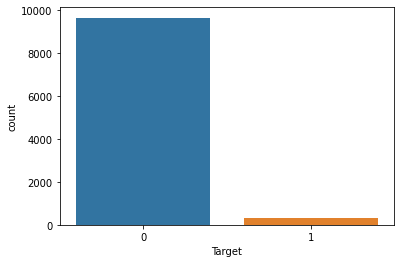

In [ ]:
sns.countplot(machine['Target'])

To partially solve this issue, without loosing too much data concerning function machines, **we are going to rebalance the dataset by removing rows of functional machines**. This removal has to be **random**, because we noticed that the dataset is partially ordered so we can't remove the first 9000 rows (matching the functional condition 'Target'= 0)  for example, it would biais the dataset. It corresponds to a "balance situation" (only **2x times** more functional machines than non-functional, instead of **28x times** at the beggining). That's why we **shuffle** our dataset before removing rows.

In [ ]:
# We shuffle the dataset and remove rows matching the condition Target=0 (which defines functional machines)

machine_reducedNB2=machine.copy()
machine_reducedNB2=shuffle(machine_reducedNB2)

sample=machine.iloc[1:9000,:]
upper = np.where(sample['Target'] == 0)
machine_reducedNB2.drop(upper[0], inplace = True)

machine_bin_reduced=BinFunction(machine_reducedNB2.copy(),labels_quartiles,0.25)

#Encode column 'Type' separately because it's already discrete values
label_type=LabelEncoder()
machine_bin_reduced['Type']=label_type.fit_transform(machine_bin_reduced['Type'])

#separation training and test

X=machine_bin_reduced.drop(['Target'],axis=1)
y=machine_bin_reduced['Target']

for i in range(4):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

  #We use a Categorical Naive Bayes model
  CTclf = CategoricalNB()
  CTclf.fit(X_train, y_train)

  #Then we evaluate our model
  preds = CTclf.predict(X_test)
  print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       321
           1       0.25      0.22      0.24         9

    accuracy                           0.96       330
   macro avg       0.61      0.60      0.61       330
weighted avg       0.96      0.96      0.96       330

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       320
           1       0.22      0.20      0.21        10

    accuracy                           0.95       330
   macro avg       0.60      0.59      0.59       330
weighted avg       0.95      0.95      0.95       330

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       321
           1       0.45      0.56      0.50         9

    accuracy                           0.97       330
   macro avg       0.72      0.77      0.74       330
weighted avg       0.97      0.97      0.97       330

              preci

The rebalanced data model provides more satisfying results: removing 9000 values out of 9661, to have a dataset of *661 functional machines* (regarding the target) and *339 non-functional machines* **increase in average the precision by 20% and recall by 30%**

##5.2 **Logistic Regression**

####5.2.1 Model 1: Basic Logistic Regression

In [ ]:
#separation training and test
machine_data=machine.copy()
print(machine_data)
attributes=machine_data.drop(['Target'], axis =1)
target=machine_data['Target']
attributes_training, attributes_test, target_training, target_test = train_test_split(attributes, target, test_size = 0.1, random_state =34 )
attributes_training.head()

      Type  Air temperature [K]  Process temperature [K]  \
0        2                298.1                    308.6   
1        1                298.2                    308.7   
2        1                298.1                    308.5   
3        1                298.2                    308.6   
4        1                298.2                    308.7   
...    ...                  ...                      ...   
9995     2                298.8                    308.4   
9996     0                298.9                    308.4   
9997     2                299.0                    308.6   
9998     0                299.0                    308.7   
9999     2                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  
0                       1551         42.8                0       0  
1                       1408         46.3                3       0  
2                       1498         49.4                5       0  
3  

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
7191,1,300.3,310.3,1629,34.1,52
2584,1,299.1,308.8,1502,46.7,197
1400,0,298.9,310.1,1366,62.7,161
8644,2,297.6,308.5,1443,38.2,85
2122,2,299.2,308.8,1523,38.9,112


In [ ]:
#Normalize the values of each columns

sc=StandardScaler()
attributes_training_normalized = sc.fit_transform(attributes_training)
attributes_test_normalized = sc.transform(attributes_test)
print(attributes_training)

      Type  Air temperature [K]  Process temperature [K]  \
7191     1                300.3                    310.3   
2584     1                299.1                    308.8   
1400     0                298.9                    310.1   
8644     2                297.6                    308.5   
2122     2                299.2                    308.8   
...    ...                  ...                      ...   
5667     1                302.2                    311.4   
324      2                297.8                    308.5   
3157     2                300.4                    309.7   
5993     2                300.7                    310.6   
5242     1                303.7                    313.1   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  
7191                    1629         34.1               52  
2584                    1502         46.7              197  
1400                    1366         62.7              161  
8644                    1443       

In [ ]:
#Create and run the LogisticRegression Model

modelLR = LogisticRegression()
modelLR.fit(attributes_training_normalized,target_training)
prediction_test_normalized = modelLR.predict(attributes_test_normalized)
print(classification_report(target_test, prediction_test_normalized))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       964
           1       0.67      0.17      0.27        36

    accuracy                           0.97      1000
   macro avg       0.82      0.58      0.62      1000
weighted avg       0.96      0.97      0.96      1000



####5.2.2 Model 2: Logistic Regression **(without standardisation)**

Let's see if the standardization has a real impact on the results: we will train our datset with LR and MLP without standardisating the data and notice if there is any difference.

In [ ]:
#Compare to the results without the standardisation

modelLR = LogisticRegression()
modelLR.fit(attributes_training,target_training)
prediction_test = modelLR.predict(attributes_test)
print(classification_report(target_test, prediction_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       964
           1       0.78      0.19      0.31        36

    accuracy                           0.97      1000
   macro avg       0.87      0.60      0.65      1000
weighted avg       0.96      0.97      0.96      1000



In [ ]:
#What weights impact the most the result

weights = pd.Series(modelLR.coef_[0], index=attributes.columns.values)
print(weights)

Type                      -0.047972
Air temperature [K]        0.854748
Process temperature [K]   -0.942071
Rotational speed [rpm]     0.011674
Torque [Nm]                0.283668
Tool wear [min]            0.013227
dtype: float64


##5.3 **Multilayer Perceptron**

####5.3.1 Model 1: Multilayer Perceptron **(with Standardization)**

In [ ]:
#Create and run the MLP Model

modelMLP = neural_network.MLPClassifier(max_iter=50000)
modelMLP.fit(attributes_training_normalized,target_training)
target_prediction_normalized = modelMLP.predict(attributes_test_normalized)
print(classification_report(target_test, target_prediction_normalized))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       964
           1       0.76      0.53      0.62        36

    accuracy                           0.98      1000
   macro avg       0.87      0.76      0.81      1000
weighted avg       0.97      0.98      0.97      1000



####5.3.2 Model 2: Multilayer Perceptron **(without Standardization)**

In [ ]:
#Compare to the results without the standardisation

modelMLP = neural_network.MLPClassifier(max_iter=50000)
modelMLP.fit(attributes_training,target_training)
target_prediction=modelMLP.predict(attributes_test)
print(classification_report(target_test, target_prediction))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       964
           1       0.30      0.44      0.36        36

    accuracy                           0.94      1000
   macro avg       0.64      0.70      0.66      1000
weighted avg       0.95      0.94      0.95      1000



We observe globally a bit less performance without the stan

##5.4 **Cross validation of LR and MLP** (with or without standardization)

In [ ]:
#Cross validation : we'll change the samples used for training and testing 



def classification(X,y,n,j):  #X : the attributes / y : the target / n : number of iterations / j : number of samples we'll run through the models
    accuracy_MLP_norm=0
    accuracy_LR_norm=0
    precision_MLP_norm=0
    precision_LR_norm=0
    recall_MLP_norm=0
    recall_LR_norm=0

    accuracy_MLP=0
    accuracy_LR=0
    precision_MLP=0
    precision_LR=0
    recall_MLP=0
    recall_LR=0
    
    
    for i in range(j) :
        
        attributes_training, attributes_test, target_training, target_test = train_test_split(attributes, target, test_size = 0.1, random_state =i )
        
        sc=StandardScaler()
        attributes_training_normalized = sc.fit_transform(attributes_training)
        attributes_test_normalized = sc.transform(attributes_test)
        
        #LR normalized
        modelLR = LogisticRegression()
        modelLR.fit(attributes_training_normalized,target_training)
        prediction_test_normalized = modelLR.predict(attributes_test_normalized)
        
        accuracy_LR_norm+=metrics.accuracy_score(target_test, prediction_test_normalized)
        precision_LR_norm+=metrics.precision_score(target_test, prediction_test_normalized)
        recall_LR_norm+=metrics.recall_score(target_test, prediction_test_normalized)


        #LR not normalized

        modelLR = LogisticRegression()
        modelLR.fit(attributes_training,target_training)
        prediction_test = modelLR.predict(attributes_test)

        accuracy_LR+=metrics.accuracy_score(target_test, prediction_test)
        precision_LR+=metrics.precision_score(target_test, prediction_test)
        recall_LR+=metrics.recall_score(target_test, prediction_test)
        

        #MLP normalized

        modelMLP = neural_network.MLPClassifier(max_iter=n)
        modelMLP.fit(attributes_training_normalized,target_training)
        target_prediction_normalized = modelMLP.predict(attributes_test_normalized)
        
        accuracy_MLP_norm+=metrics.accuracy_score(target_test, target_prediction_normalized)
        precision_MLP_norm+=metrics.precision_score(target_test, target_prediction_normalized)
        recall_MLP_norm+=metrics.recall_score(target_test, target_prediction_normalized)
        

        #MLP not normalized

        modelMLP = neural_network.MLPClassifier(max_iter=n)
        modelMLP.fit(attributes_training,target_training)
        target_prediction=modelMLP.predict(attributes_test)

        accuracy_MLP+=metrics.accuracy_score(target_test, target_prediction)
        precision_MLP+=metrics.precision_score(target_test, target_prediction)
        recall_MLP+=metrics.recall_score(target_test, target_prediction)

        
    print('The accuracy for LR-model with normalized is in average :', accuracy_LR_norm/j , 'and not normalized is :', accuracy_LR/j )
    print('The precision for LR-model with normalized is in average :', precision_LR_norm/j, 'and not normalized is :',precision_LR/j)
    print('The recall for LR-model with normalized is in average :', recall_LR_norm/j, 'and not normalized is :',recall_LR/j)

    print('The accuracy for MLP-model with normalized is in average :', accuracy_MLP_norm/j , 'and not normalized is :',accuracy_MLP/j)
    print('The precision for MLP-model with normalized is in average :', precision_MLP_norm/j, 'and not normalized is :',precision_MLP/j)
    print('The recall for MLP-model with normalized is in average :', recall_MLP_norm/j, 'and not normalized is :',recall_MLP/j)


classification(attributes,target,50000,5)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The accuracy for LR-model with normalized is in average : 0.9662 and not normalized is : 0.9658
The precision for LR-model with normalized is in average : 0.7634920634920634 and not normalized is : 0.7114285714285715
The recall for LR-model with normalized is in average : 0.16199723479135245 and not normalized is : 0.16057273336685102
The accuracy for MLP-model with normalized is in average : 0.9812000000000001 and not normalized is : 0.9649999999999999
The precision for MLP-model with normalized is in average : 0.825925925925926 and not normalized is : 0.6846153846153846
The recall for MLP-model with normalized is in average : 0.6336538461538461 and not normalized is : 0.08157679738562092


####5.4 **Model 3: LR and MLP with rebalanced dataset**

As seen before, bad results on recall and precision might be due to the unbalanced dateset we use. Let's change the data set from a 10000 lines with 339 Target equal to 1 to a 6000 lines dataset with 339 Target equal to 1

In [ ]:
from sklearn.metrics._plot.precision_recall_curve import precision_recall_curve
machine_reduced=machine.copy()
machine_reduced=shuffle(machine_reduced)

sample=machine.iloc[1:4000,:]
upper = np.where(sample['Target'] == 0)
machine_reduced.drop(upper[0], inplace = True)

attributes=machine_reduced.drop(['Target'], axis =1)
target=machine_reduced['Target']

classification(attributes,target,50000,5)
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The accuracy for LR-model with normalized is in average : 0.9666121112929623 and not normalized is : 0.9675941080196399
The precision for LR-model with normalized is in average : 0.62 and not normalized is : 0.6672727272727272
The recall for LR-model with normalized is in average : 0.14102216748768473 and not normalized is : 0.16994252873563218
The accuracy for MLP-model with normalized is in average : 0.9839607201309329 and not normalized is : 0.9584288052373159
The precision for MLP-model with normalized is in average : 0.8195649379859906 and not normalized is : 0.2704761904761905
The recall for MLP-model with normalized is in average : 0.7092077175697865 and not normalized is : 0.19261904761904763


In [ ]:
from sklearn.metrics._plot.precision_recall_curve import precision_recall_curve
machine_reduced=machine.copy()
machine_reduced=shuffle(machine_reduced)

sample=machine.iloc[1:9000,:]
upper = np.where(sample['Target'] == 0)
machine_reduced.drop(upper[0], inplace = True)

attributes=machine_reduced.drop(['Target'], axis =1)
target=machine_reduced['Target']

classification(attributes,target,50000,5)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

The accuracy for LR-model with normalized is in average : 0.9712121212121213 and not normalized is : 0.9696969696969697
The precision for LR-model with normalized is in average : 0.4 and not normalized is : 0.4
The recall for LR-model with normalized is in average : 0.13 and not normalized is : 0.09
The accuracy for MLP-model with normalized is in average : 0.9712121212121213 and not normalized is : 0.9666666666666668
The precision for MLP-model with normalized is in average : 0.6 and not normalized is : 0.29333333333333333
The recall for MLP-model with normalized is in average : 0.31999999999999995 and not normalized is : 0.34


#6. Conclusion

To conclude:

- Regarding all models (NB, LR, MLP), there is an improvement when we rebalance the dataset by removing rows from the over-representated part. The best way to rebalance the dataset would have been to collect more data concerning the under-representated data category, rather than removing rows from the over-represented one.

- Regarding Naive Bayes, models training confirm an intuitive assumption , which is the more bins there are the better the precision and the recall are.

- Regarding LR and MLP, normalization do not massively increase precision and recall.

Way of improvements:

- Another way to rebalance dataset would have been to remove outlier values: here because we don't have that much values, we didn't apply an algorithm to do so.